# MIT-GSL Uruguay 

## January 2020

-----

# Week - 2 | Lesson - 04 
# NLP: Product embeddings in Keras

1. After introducing the concept of embeddings through NLP, we extend the notion of embeddings to other settings
2. Note that embeddings are dense continuous representations for discrete, sparse tokens - this makes embeddings widely applicable
3. We will use the concept of embeddings to understand the world of e-commerce better 

---

# Word2Vec and its Applications to Market-Basket Data

# Instacart Grocery Dataset

### Source: https://www.instacart.com/datasets/grocery-shopping-2017

1. Instacart is an online grocery delivery service
2. They have made available 3M grocery orders for over 200K users
3. They provide between 4 to 100 orders for each user and each order contains the sequence of products purchased
4. We also have a brief description of the products

### Overview:
1. We will use this data to build an understanding of word embeddings and investigate their application to downstream tasks
2. For this purpose, we will consider each purchase basket to be a sentence with an unordered sequence of words

---

# 0. Import Modules

In [1]:
# ==============================================
# 0. Module imports
# ==============================================

import pandas as pd
pd.options.display.max_colwidth = 100
import numpy as np
from itertools import product
import csv
import collections
import random

# w2v
import gensim

# text processing
from nltk import sent_tokenize, word_tokenize
from nltk.tokenize import ToktokTokenizer
import string
import re # regular expressions
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity

# T-Sne
#import umap
#from openTSNE import TSNE, TSNEEmbedding, affinity, initialization
#from openTSNE import initialization
#from openTSNE.callbacks import ErrorLogger
from sklearn.manifold import TSNE


# utils
from sklearn import utils


# parallel processing
import multiprocessing
from joblib import delayed, Parallel

# time code
import time

# 2-d visualiztion
%matplotlib inline
from ggplot import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import os

import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
# ===============================================
# keras modules
# ===============================================

from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Dense, Reshape, merge, Flatten, Concatenate, Activation, Multiply
from keras.layers.embeddings import Embedding
from keras.layers.merge import dot
from keras.layers.merge import Dot
from keras.preprocessing.sequence import skipgrams
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras import optimizers
from keras.callbacks import History 
from keras import regularizers

Using TensorFlow backend.


In [3]:
# =========================================================
# set directories
# =========================================================

import os
EC2 = True  # If using EC2 (for data directory/paths)

# Select path based off of local or remote
if not EC2:
    wd = "/pool001/madhavk/gsl-uruguay/W-02-NLP/"
else:
    wd = "/home/ubuntu/machine_learning_aws/"
os.chdir(wd)

if not EC2:
    # raw data
    raw_data_dir = "nlp-data/in-grocery/instacart_2017_05_01/"
    # processed data
    process_dir = "nlp-data/in-grocery/prepared-data/"  
else:
    # raw data
    raw_data_dir = "data/in-grocery/instacart_2017_05_01"
    # processed data
    process_dir = "data/in-grocery/prepared-data/"

In [4]:
#===============================================
# processed files
#===============================================
os.listdir(process_dir)

['orders-split-v1.csv',
 'all-orders-wide-v1.csv',
 'all-orders-long-v1.csv',
 'products-merged-v1.csv']

In [5]:
#===============================================
# global parameters
#===============================================

# show entire value of cell in pandas
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 500)

# number of cpus
cpus = multiprocessing.cpu_count()
f"Number of CPUs: {cpus}"

'Number of CPUs: 4'

---

# 1. Prepare data

In [6]:
# start pool process for parallel procressing
pool = multiprocessing.Pool(processes = cpus)

In [7]:
# =========================================================
# order-level data
# =========================================================

orders_wide = pd.read_csv(process_dir + "all-orders-wide-v1.csv")
print(orders_wide.shape)

# =========================================================
# orders meta-data
# =========================================================

orders_meta = pd.read_csv(process_dir + "orders-split-v1.csv")
print(orders_meta.shape)

# =========================================================
# merge orders-wide and orders-meta
# =========================================================

orders_wide.drop(labels = "eval", axis = 1, inplace = True)

# merge
orders_wide = pd.merge(orders_wide, orders_meta[["order_id", "user_id", "eval"]],
                       on = "order_id", how = "left")
print(orders_wide.shape)

# clear some space
del orders_meta


# product info data
products = pd.read_csv(process_dir + "products-merged-v1.csv")
print(products.shape)
products["product_id"] = products["product_id"].astype(str)

#===============================================
# split train-val-test
#===============================================

train = orders_wide.loc[orders_wide["eval"].isin(["prior", "train"]), :]
val = orders_wide.loc[orders_wide["eval"] == "val", :]
test = orders_wide.loc[orders_wide["eval"] == "test", :]
print("train size:", train.shape)
print("val size:", val.shape)
print("test size:", test.shape)

# clear more space
del orders_wide

#===============================================
# randomly sample training data
#===============================================

sample_size = 1000000
train = train.sample(n = sample_size)
train = train.reset_index(drop = True)
print(train.shape)

# training sentences
t0 = time.time()
train_orders = pool.map(word_tokenize, train["product_id"])
t1 = time.time()
print(len(train_orders))

# validation sentences
t0 = time.time()
val_orders = pool.map(word_tokenize, val["product_id"])
t1 = time.time()
print(len(val_orders))

# test sentences
t0 = time.time()
test_orders = pool.map(word_tokenize, test["product_id"])
t1 = time.time()
print(len(test_orders))

(3152555, 4)
(3346083, 7)
(3152555, 5)
(49688, 6)
train size: (3075412, 5)
val size: (38701, 5)
test size: (38442, 5)
(1000000, 5)
1000000
38701
38442


## Current state of data

In [8]:
display(train.head())

,order_id,product_id,num_products,user_id,eval
0,3251145,44292 28572 21376 19348 26767 44919 48366 554,8,68649,prior
1,464499,9363 4367 18531 2187 11933 46270 36117 23734 27845 20034 37065 23375 41844,13,164432,train
2,2024911,30776 16262 44449 45535 27845 18889 17706 3952 30391,9,119021,prior
3,3056462,31060 13838 18957 28913 3148,5,19967,prior
4,1693926,47209 46906 13988 44765 21903 17988 45578 47766 10246 46979 49383 30391 7054 25295 16185 1158,16,81433,prior


In [9]:
train["product_id"][0:3]

0    44292 28572 21376 19348 26767 44919 48366 554                             
1    9363 4367 18531 2187 11933 46270 36117 23734 27845 20034 37065 23375 41844
2    30776 16262 44449 45535 27845 18889 17706 3952 30391                      
Name: product_id, dtype: object

In [10]:
train_orders[0:3]

[['44292', '28572', '21376', '19348', '26767', '44919', '48366', '554'],
 ['9363',
  '4367',
  '18531',
  '2187',
  '11933',
  '46270',
  '36117',
  '23734',
  '27845',
  '20034',
  '37065',
  '23375',
  '41844'],
 ['30776',
  '16262',
  '44449',
  '45535',
  '27845',
  '18889',
  '17706',
  '3952',
  '30391']]

### In-class exercise

In [11]:
# Print the first 3 rows of val

In [12]:
# Print the first 3 elements of list val_orders

----

# 2. Writing our own Word2Vec in Keras

- We are now going to train product embeddings in Keras + Tensorflow
- In order to this, we need to transform the data in a format that Keras/Tensorflow will accept

## Tasks:
### 1. Count frequency of all words in dataset
     1.1. Used to sample words based on frequency
### 2. Create word-to-index dictionary
    2.1. The index for each word serves as a lookup value in the embedding matrix
    2.2. The dictionary is created in order of frequency
### 3. Convert entire dataset from a sequence of words to a sequences of indices

---

## 2.1. Count frequency of each word in vocabulary

In [13]:
def WordFrequency(train_data, max_words = 10000):
    '''
    Assumes train data is a list of lists
    '''
    train_flat = [item for sublist in train_data for item in sublist] 
    count = [['UNK', -1]]
    count.extend(collections.Counter(train_flat).most_common(max_words))
    return count

In [14]:
# flatten train-orders to create one giant list
word_freq = WordFrequency(train_data = train_orders)
len(word_freq)

10001

In [15]:
# inspect
word_freq[0:5]

[['UNK', -1],
 ('24852', 155598),
 ('13176', 124445),
 ('21137', 87362),
 ('21903', 79208)]

----

## 2.2. Create Word-to-Index and Index-to-Word dictionaries
### 2.2.1. These are used to create look-up embedding matrices
### 2.2.2. They are ordered as per frequency of the corresponding word in the vocabulary

In [16]:
# create word-index dictionary
def Word2Index(word_count):
    dictionary = dict()
    for word, _ in word_count:
        dictionary[word] = len(dictionary)
    # index-word reveresed dictionary
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return dictionary, reversed_dictionary

In [17]:
word_ix, ix_word = Word2Index(word_count = word_freq)

In [18]:
word_ix

{'UNK': 0,
 '24852': 1,
 '13176': 2,
 '21137': 3,
 '21903': 4,
 '47209': 5,
 '47766': 6,
 '47626': 7,
 '16797': 8,
 '26209': 9,
 '27966': 10,
 '27845': 11,
 '22935': 12,
 '24964': 13,
 '45007': 14,
 '39275': 15,
 '49683': 16,
 '28204': 17,
 '5876': 18,
 '8277': 19,
 '40706': 20,
 '4920': 21,
 '30391': 22,
 '45066': 23,
 '42265': 24,
 '49235': 25,
 '19057': 26,
 '44632': 27,
 '4605': 28,
 '21616': 29,
 '37646': 30,
 '17794': 31,
 '30489': 32,
 '27104': 33,
 '31717': 34,
 '27086': 35,
 '44359': 36,
 '46979': 37,
 '8518': 38,
 '28985': 39,
 '41950': 40,
 '26604': 41,
 '5077': 42,
 '34126': 43,
 '39877': 44,
 '22035': 45,
 '43352': 46,
 '35951': 47,
 '10749': 48,
 '9076': 49,
 '21938': 50,
 '24184': 51,
 '43961': 52,
 '34969': 53,
 '19660': 54,
 '46667': 55,
 '48679': 56,
 '25890': 57,
 '39928': 58,
 '31506': 59,
 '12341': 60,
 '24838': 61,
 '5450': 62,
 '22825': 63,
 '5785': 64,
 '35221': 65,
 '28842': 66,
 '33731': 67,
 '44142': 68,
 '8174': 69,
 '8424': 70,
 '27521': 71,
 '33198': 72,
 

In [19]:
ix_word

{0: 'UNK',
 1: '24852',
 2: '13176',
 3: '21137',
 4: '21903',
 5: '47209',
 6: '47766',
 7: '47626',
 8: '16797',
 9: '26209',
 10: '27966',
 11: '27845',
 12: '22935',
 13: '24964',
 14: '45007',
 15: '39275',
 16: '49683',
 17: '28204',
 18: '5876',
 19: '8277',
 20: '40706',
 21: '4920',
 22: '30391',
 23: '45066',
 24: '42265',
 25: '49235',
 26: '19057',
 27: '44632',
 28: '4605',
 29: '21616',
 30: '37646',
 31: '17794',
 32: '30489',
 33: '27104',
 34: '31717',
 35: '27086',
 36: '44359',
 37: '46979',
 38: '8518',
 39: '28985',
 40: '41950',
 41: '26604',
 42: '5077',
 43: '34126',
 44: '39877',
 45: '22035',
 46: '43352',
 47: '35951',
 48: '10749',
 49: '9076',
 50: '21938',
 51: '24184',
 52: '43961',
 53: '34969',
 54: '19660',
 55: '46667',
 56: '48679',
 57: '25890',
 58: '39928',
 59: '31506',
 60: '12341',
 61: '24838',
 62: '5450',
 63: '22825',
 64: '5785',
 65: '35221',
 66: '28842',
 67: '33731',
 68: '44142',
 69: '8174',
 70: '8424',
 71: '27521',
 72: '33198',
 

## 2.3. Convert entire data set from text to indices


In [31]:
# convert data to index
def Data2Index(train_data, word_ix, ret_unk_cnt = False):
    data = list()
    global unk_count
    unk_count = 0
    for order in train_data:
        ord_data = []
        for word in order:
            if word in word_ix:
                index = word_ix[word]
            else:
                index = 0
                unk_count += 1
            ord_data.append(index)
        data.append(ord_data)
    if ret_unk_cnt:
        return(data, unk_count)
    else:
        return(data)

In [32]:
# training orders
train_orders_ix = Data2Index(train_data = train_orders, word_ix = word_ix, ret_unk_cnt = False)

In [33]:
train_orders[0:3]

[['44292', '28572', '21376', '19348', '26767', '44919', '48366', '554'],
 ['9363',
  '4367',
  '18531',
  '2187',
  '11933',
  '46270',
  '36117',
  '23734',
  '27845',
  '20034',
  '37065',
  '23375',
  '41844'],
 ['30776',
  '16262',
  '44449',
  '45535',
  '27845',
  '18889',
  '17706',
  '3952',
  '30391']]

In [34]:
train_orders_ix[0:3]

[[838, 2090, 252, 116, 2120, 9122, 5623, 3617],
 [7749, 629, 145, 6291, 3095, 9357, 2196, 165, 11, 2749, 645, 187, 131],
 [178, 680, 311, 225, 11, 4621, 316, 208, 22]]

In [35]:
# total number of training orders
len(train_orders)

1000000

In [36]:
# val orders
val_orders_ix = Data2Index(train_data = val_orders, word_ix = word_ix, ret_unk_cnt = False)
print(len(val_orders_ix))

38701


----

### In-class exercise

In [26]:
# convert all the test orders to indices using the Data2Index() function

----

# A.1: Intro to Neural Networks

In [37]:
## code to download imdb data and load into memory
import numpy as np
old = np.load
np.load = lambda *a,**k: old(*a,**k,allow_pickle=True)
# call load_data with allow_pickle implicitly set to true
from keras.datasets import imdb
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)
np.load = old
del(old)

17465344/17464789 [==============================] - 0s 0us/step


In [38]:
print(x_train.shape)
print(y_train.shape)

(25000,)
(25000,)


In [39]:
x_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [40]:
y_train[0:5]

array([1, 0, 0, 1, 0])

In [41]:
# total number of words
print(max([max(sequence) for sequence in x_train]))

9999


In [42]:
# decode back from indices to words
word_index = imdb.get_word_index()

1646592/1641221 [==============================] - 0s 0us/step


In [43]:
# reverse the word index by mapping indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in x_train[0]])
print(decoded_review)

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

In [44]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

In [45]:
x_train = vectorize_sequences(x_train)
x_test = vectorize_sequences(x_test)

In [46]:
print(len(x_train[0]))

10000


In [47]:
print(len(x_test[0]))

10000


In [48]:
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

In [49]:
from keras import models
from keras import layers

In [50]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [51]:
from keras import optimizers

In [52]:
model.compile(optimizer= 'rmsprop',
                      loss= 'binary_crossentropy',
                      metrics= ['accuracy'])

In [53]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [54]:
# create validation data 
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

In [55]:
# create validation labels
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [56]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs= 5,
                    batch_size= 128,
                    validation_data= (x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/5
15000/15000 [==============================] - 3s 173us/step - loss: 0.3980 - acc: 0.8413 - val_loss: 0.2830 - val_acc: 0.8885
Epoch 2/5
15000/15000 [==============================] - 2s 144us/step - loss: 0.2100 - acc: 0.9211 - val_loss: 0.2753 - val_acc: 0.8902
Epoch 3/5
15000/15000 [==============================] - 2s 143us/step - loss: 0.1505 - acc: 0.9467 - val_loss: 0.3022 - val_acc: 0.8879
Epoch 4/5
15000/15000 [==============================] - 2s 144us/step - loss: 0.1137 - acc: 0.9598 - val_loss: 0.3440 - val_acc: 0.8842
Epoch 5/5
15000/15000 [==============================] - 2s 143us/step - loss: 0.0832 - acc: 0.9721 - val_loss: 0.3832 - val_acc: 0.8785


In [57]:
# plot training and validation accuracy
acc = history.history['acc'] # retreive training accuracy from history
val_acc = history.history['val_acc'] # retreive validation accuracy from history
loss = history.history['loss'] # retreive training loss from history
val_loss = history.history['val_loss'] # retreive validation loss from history

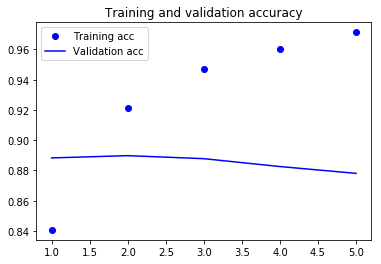

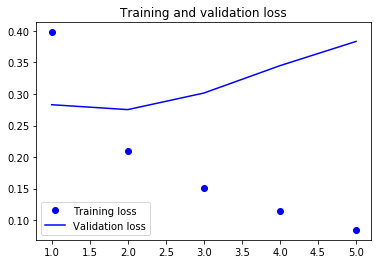

In [54]:
# two plots - one for loss and the other for accuract
epochs = range(1, len(acc) + 1)

# -- plot 1: Number of epochs vs. accuracy
plt.plot(epochs, acc, 'bo', label= 'Training acc')
plt.plot(epochs, val_acc, 'b', label= 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# -- plot 2: Number of epochs vs. loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

------

# A.2: A slightly larger neural network

In [55]:
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [56]:
model.compile(optimizer= 'rmsprop',
                      loss= 'binary_crossentropy',
                      metrics= ['accuracy'])

In [57]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 320,577
Trainable params: 320,577
Non-trainable params: 0
_________________________________________________________________


In [58]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs= 10,
                    batch_size= 128,
                    validation_data= (x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/10
15000/15000 [==============================] - 2s 142us/step - loss: 0.3788 - acc: 0.8447 - val_loss: 0.3188 - val_acc: 0.8689
Epoch 2/10
15000/15000 [==============================] - 2s 120us/step - loss: 0.2025 - acc: 0.9241 - val_loss: 0.3065 - val_acc: 0.8804
Epoch 3/10
15000/15000 [==============================] - 2s 116us/step - loss: 0.1457 - acc: 0.9463 - val_loss: 0.3850 - val_acc: 0.8631
Epoch 4/10
15000/15000 [==============================] - 2s 109us/step - loss: 0.1090 - acc: 0.9603 - val_loss: 0.4454 - val_acc: 0.8574
Epoch 5/10
15000/15000 [==============================] - 2s 111us/step - loss: 0.0769 - acc: 0.9733 - val_loss: 0.4424 - val_acc: 0.8687
Epoch 6/10
15000/15000 [==============================] - 2s 114us/step - loss: 0.0578 - acc: 0.9799 - val_loss: 0.5102 - val_acc: 0.8629
Epoch 7/10
15000/15000 [==============================] - 2s 111us/step - loss: 0.0379 - acc: 0.9870 - val_loss: 0.5333 - 

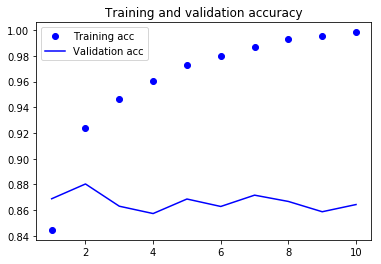

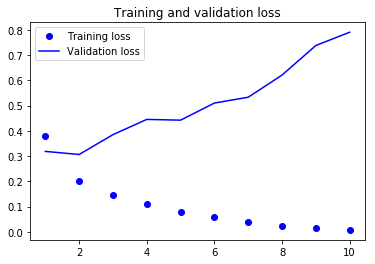

In [59]:
# plot training and validation accuracy
acc = history.history['acc'] # retreive training accuracy from history
val_acc = history.history['val_acc'] # retreive validation accuracy from history
loss = history.history['loss'] # retreive training loss from history
val_loss = history.history['val_loss'] # retreive validation loss from history

# two plots - one for loss and the other for accuract
epochs = range(1, len(acc) + 1)

# -- plot 1: Number of epochs vs. accuracy
plt.plot(epochs, acc, 'bo', label= 'Training acc')
plt.plot(epochs, val_acc, 'b', label= 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# -- plot 2: Number of epochs vs. loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

-----

### In-class exercise

In [60]:
# Build the following neural network:

# 4 layers
# 1. Layer 1: 64 nodes
# 2. Layer 2: 64 nodes
# 3. Layer 3: 32 nodes
# 4. Layer 4: 32 nodes

In [61]:
# plot the accuracy and the loss for training and validation data

---

# 3. Define embedding matrices and model


## 3.1. Model parameters

In [58]:
# embedding parameters
vocab_size = len(word_ix)
input_size = vocab_size
emb_size = 100

In [59]:
# size of vocabulary
f"Vocab size: {vocab_size}"

'Vocab size: 10001'

## 3.2. Embedding layers
### We use two embedding layers -- one for the target product and one for the context product

In [61]:
# define input layers
input_target = Input((1,))
input_target


<tf.Tensor 'input_2:0' shape=(?, 1) dtype=float32>

In [62]:
input_context = Input((1,))
input_context

<tf.Tensor 'input_3:0' shape=(?, 1) dtype=float32>

In [63]:
# define embedding layers
# target
target = Embedding(input_dim = vocab_size, output_dim= emb_size, name = "rho")(input_target)
target = Reshape(target_shape = (emb_size, 1))(target)
target

<tf.Tensor 'reshape_1/Reshape:0' shape=(?, 100, 1) dtype=float32>

In [64]:
# context
context = Embedding(input_dim = vocab_size, output_dim= emb_size, name = "alpha")(input_context)
context = Reshape(target_shape = (emb_size, 1))(context)
context

<tf.Tensor 'reshape_2/Reshape:0' shape=(?, 100, 1) dtype=float32>

In [65]:
# concatenate model inputs and outputs
input_model = [input_target, input_context]
input_model

[<tf.Tensor 'input_2:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'input_3:0' shape=(?, 1) dtype=float32>]

In [66]:
output_embeddings = Dot(axes = 1)([target, context])
output_embeddings

<tf.Tensor 'dot_1/MatMul:0' shape=(?, 1, 1) dtype=float32>

In [67]:
# resize embeddings
#output_model = Reshape((1,))(output_embeddings)
output_model = Flatten()(output_embeddings)
output_model

<tf.Tensor 'flatten_1/Reshape:0' shape=(?, ?) dtype=float32>

In [69]:
# complete model
output_model = Dense(1, activation = "sigmoid")(output_model)

## 3.3. Complete model

In [70]:
# define as keras model
pemb_model = Model(inputs = input_model, outputs = output_model)
pemb_model

In [71]:
# optimizer
adam = optimizers.Adam(lr = 0.01, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
adam

In [72]:
# compile model
pemb_model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['acc'])

In [73]:
# model summary
pemb_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
rho (Embedding)                 (None, 1, 100)       1000100     input_2[0][0]                    
__________________________________________________________________________________________________
alpha (Embedding)               (None, 1, 100)       1000100     input_3[0][0]                    
__________________________________________________________________________________________________
reshape_1 

# 3.4. Initial product embeddings

In [74]:
# initial weights - rho
init_alpha = pemb_model.get_layer("alpha").get_weights()[0]
print(init_alpha.shape)

(10001, 100)


In [75]:
# check the (random) initial embeddings for a product
init_alpha[345]

array([-0.00229377,  0.02260712, -0.04887443,  0.04669727,  0.00693572,
       -0.04095336,  0.04896779,  0.04047385,  0.0274269 , -0.01983752,
       -0.02520435,  0.0416998 , -0.03695747,  0.03434027, -0.02796131,
        0.0316982 ,  0.01361919,  0.01016325, -0.02761798, -0.01371578,
       -0.00273164,  0.00370067, -0.04076353,  0.02618   , -0.04119663,
       -0.02851044, -0.04046534,  0.04173764,  0.00343903, -0.00416269,
       -0.0351143 ,  0.00936069,  0.04776832, -0.03702711, -0.02913542,
       -0.00241365,  0.04610521, -0.02618657,  0.00688702,  0.0474383 ,
       -0.03507974, -0.0462783 , -0.03117225, -0.03499422,  0.02864763,
        0.01686816, -0.02897003, -0.01091207, -0.01279555,  0.00956547,
        0.01302669,  0.03293454,  0.04187961,  0.01452627,  0.03906555,
        0.00314869,  0.00388011, -0.03209443, -0.00782126, -0.04356505,
        0.03130679, -0.01575067,  0.0050344 ,  0.02431079,  0.01700599,
        0.00571697, -0.00110197,  0.00154674, -0.04868156,  0.00

----

# 4. Prepare batches for model

In [76]:
# sampling table
sampling_table = sequence.make_sampling_table(vocab_size)

In [77]:
# context size and negative samples
ns = 10.0
cs = 5

In [78]:
def BatchGenerator(training = True):
    i = 0
    while True:
        if training:
            order_data = random.sample(train_orders_ix, batch_size)
        else:
            order_data = random.sample(val_orders_ix, batch_size)
        iv = []
        dv =[]
        for d in order_data:
            couples, labels = skipgrams(d, vocabulary_size = vocab_size, window_size = cs,
                                        negative_samples = ns, sampling_table = sampling_table)
            iv = iv + couples
            dv = dv + labels
        i += 1
        X = np.array(iv, dtype = "int32")
        X = [X[:, 0], X[:, 1]]
        yield X, dv

In [79]:
# parameters
batch_size = 64
num_epochs = 1

# training data generator
train_gen = BatchGenerator(training = True)

# validation data generator
val_gen = BatchGenerator(training = False)

# history
history = History()

----

# 5. Train model
### This could take a while

In [80]:
# train model
t0 = time.time()
pemb_model.fit_generator(generator = train_gen, 
                         steps_per_epoch = len(train_orders_ix)//batch_size,
                         epochs = num_epochs,
                         workers = cpus, 
                         use_multiprocessing = True, 
                         validation_data = val_gen,
                         validation_steps = len(val_orders_ix)//batch_size,
                         callbacks = [history])
t1 = time.time()

Epoch 1/1
15625/15625 [==============================] - 1012s 65ms/step - loss: 0.2101 - acc: 0.9236 - val_loss: 0.2074 - val_acc: 0.9250


In [81]:
# time taken
t1 - t0

1012.8899562358856

In [82]:
# history
history.history

{'val_loss': [0.2073759828767031],
 'val_acc': [0.9249741883445414],
 'loss': [0.2104291912081576],
 'acc': [0.9235291871944444]}

------

# 6. Model results

In [83]:
# final weights - target words
final_alpha = pemb_model.get_layer("alpha").get_weights()[0]

In [84]:
init_alpha[61]

array([ 0.04986186, -0.04789882,  0.01951226, -0.04122198,  0.04672334,
        0.04507491, -0.03546966,  0.00937691,  0.04450944,  0.01182928,
       -0.00100102,  0.00678862,  0.00334871,  0.03376678, -0.00377641,
        0.02198884,  0.01508195,  0.02472008, -0.02153869, -0.0127754 ,
        0.01787063,  0.01696965, -0.02814552,  0.00495304,  0.00268093,
        0.03835198,  0.04136718,  0.01236654, -0.03394774, -0.01864086,
        0.04594921,  0.0022493 ,  0.01355156, -0.03198393, -0.02394328,
        0.04668833,  0.02299256,  0.02265586, -0.02812946,  0.04225438,
       -0.02851254, -0.01699164, -0.04613311, -0.04672709, -0.023542  ,
       -0.01920756, -0.04022513,  0.02948213,  0.0426428 ,  0.00094163,
        0.04493589,  0.01393257,  0.00127312, -0.0164968 ,  0.0366963 ,
       -0.00304481,  0.00445609,  0.03371544,  0.0348303 ,  0.0388342 ,
       -0.04680357, -0.00793176, -0.0408443 ,  0.00387452,  0.04577268,
        0.00930231,  0.00127349,  0.01045741, -0.01712047, -0.03

In [85]:
final_alpha[61]

array([ 2.6412091 , -1.9831928 , -0.93559736, -0.5615938 , -0.29816175,
       -0.7160668 ,  1.0861975 ,  1.3850315 , -0.09004098, -0.47310418,
        1.0779027 , -0.9830514 ,  0.40066993,  1.488021  , -2.5541155 ,
        0.9367793 , -1.2551882 , -1.7202398 ,  1.485869  , -0.16412881,
        0.14652996,  2.5123038 , -1.3181615 ,  0.62378997, -0.9696551 ,
        1.3627868 , -2.1085386 ,  1.2933009 ,  1.1886795 ,  1.1837875 ,
        0.17918177,  2.437843  , -2.0405126 , -0.27773774,  1.6827087 ,
        1.8830963 , -3.1091242 , -1.8023072 , -1.387576  , -1.5306965 ,
       -1.0295788 ,  0.5263541 , -0.97106904,  0.16882212, -2.5182068 ,
        1.0872716 , -1.2461851 , -1.9623933 , -2.8247273 ,  2.4066842 ,
       -1.8490573 ,  1.5047716 , -2.1675346 , -1.4697558 , -0.4155266 ,
        0.51214117,  2.3818438 ,  1.7780905 , -0.4898356 ,  1.6750544 ,
       -1.5034618 , -0.8248943 ,  1.5792158 , -0.40147212, -2.434791  ,
        1.0468435 ,  1.0847319 ,  0.5434255 ,  0.02017764, -0.67

In [86]:
#===============================================
# extract embeddings to data frame
#===============================================

def EmbToDataFrame(ix_word, emb_mat, col_prefix = "rho"):
    emb_df = {ix_word[i]: list(emb_mat[i]) for i in ix_word.keys()}
    emb_df = pd.DataFrame.from_dict(emb_df, orient = "columns")
    emb_df = emb_df.transpose().reset_index(drop = False)
    emb_df.columns = ["product_id"] + [col_prefix + str(i + 1) for i in range(emb_df.shape[1] - 1)]
    return emb_df

In [87]:
# get data frame from alpha matrix
alpha_df = EmbToDataFrame(ix_word, emb_mat = final_alpha, col_prefix = "alpha")
display(alpha_df.head())

,product_id,alpha1,alpha2,alpha3,alpha4,alpha5,alpha6,alpha7,alpha8,alpha9,alpha10,alpha11,alpha12,alpha13,alpha14,alpha15,alpha16,alpha17,alpha18,alpha19,alpha20,alpha21,alpha22,alpha23,alpha24,alpha25,alpha26,alpha27,alpha28,alpha29,alpha30,alpha31,alpha32,alpha33,alpha34,alpha35,alpha36,alpha37,alpha38,alpha39,alpha40,alpha41,alpha42,alpha43,alpha44,alpha45,alpha46,alpha47,alpha48,alpha49,alpha50,alpha51,alpha52,alpha53,alpha54,alpha55,alpha56,alpha57,alpha58,alpha59,alpha60,alpha61,alpha62,alpha63,alpha64,alpha65,alpha66,alpha67,alpha68,alpha69,alpha70,alpha71,alpha72,alpha73,alpha74,alpha75,alpha76,alpha77,alpha78,alpha79,alpha80,alpha81,alpha82,alpha83,alpha84,alpha85,alpha86,alpha87,alpha88,alpha89,alpha90,alpha91,alpha92,alpha93,alpha94,alpha95,alpha96,alpha97,alpha98,alpha99,alpha100
0,1,-1.146843,-1.053118,-0.557412,-0.120488,0.013031,-0.527340,-2.094234,1.181270,-0.345880,-0.220478,-0.560504,-0.600841,0.350207,-0.634588,4.228546,-3.960728,2.942970,-0.782055,-1.589139,0.952999,0.232263,1.101146,0.690405,-1.059641,-1.551115,-2.286459,2.167052,-0.101397,-1.568074,0.717543,-1.806334,0.493065,1.754820,0.220678,-1.825948,-2.386700,3.342002,2.557569,3.309105,0.665487,0.591692,-1.228375,-0.695542,1.618457,4.920903,0.064517,1.166479,0.386418,1.572636,0.540141,-0.280360,0.423016,-1.078985,-1.098527,-0.392480,0.247066,-0.630177,-0.030650,-0.948803,-2.326584,1.810242,0.770901,-0.741126,-0.337669,2.035331,-0.938313,0.301746,-0.217357,-1.703723,0.158904,0.684799,-4.962573,-0.080565,0.159280,0.607657,-0.730378,0.632870,-0.044653,1.787475,-0.290513,-0.815928,0.974109,2.202284,0.153727,-3.345642,-1.219962,1.925441,0.313240,-1.204136,-2.995980,-2.043462,-0.681574,-0.180667,-1.541021,1.998314,0.948451,3.235093,4.168147,-0.692658,-1.091187
1,10,0.347934,0.210562,-0.014617,-0.961033,0.723528,-0.294561,0.149233,-1.558537,0.130899,2.411568,0.442865,1.660886,-1.446228,-0.414065,1.022526,-1.472935,0.107729,-0.248346,0.307375,0.359593,1.814257,-0.268181,-0.168452,-0.326123,1.965906,-0.264830,-0.397227,1.169289,-0.683863,0.673845,-1.578772,-0.933306,-0.398892,-0.444688,0.408111,-0.303871,1.218695,0.266408,0.811251,-1.043761,-2.371292,-2.012559,-0.554508,0.257649,-0.172015,-0.486320,-0.185165,0.454652,-0.424234,1.181967,0.671883,0.213661,0.200500,-0.338006,-0.353236,-0.425424,0.558201,-1.339665,-1.844556,0.027825,1.138708,-1.304500,-0.485300,-0.718120,0.035514,-0.218728,0.735579,0.983964,0.601221,-0.591197,1.354033,-1.565356,0.074297,0.767671,0.639816,0.753105,2.566300,0.761434,0.725130,-1.691777,0.225710,0.789636,1.871825,0.366162,-0.130836,0.861280,-0.613201,-0.122191,-1.768520,0.169739,-0.568196,-0.373921,-0.588461,1.546434,-0.496997,-0.024336,0.649400,-0.618458,1.630054,-0.279845
2,100,-1.921470,-0.224818,1.094223,-0.343916,-0.579605,-0.186866,-2.689758,-0.627287,-1.050114,-0.913588,1.049766,0.231540,-0.985872,-3.070523,1.876046,-1.249153,1.646601,1.045084,-0.087628,2.234870,0.078474,-0.137680,1.351657,0.803762,0.477675,-1.591073,1.661633,-0.445440,-1.400072,0.325734,-2.145197,-1.029037,1.215011,-0.966229,-1.049646,-0.635434,2.950770,0.647537,1.536920,-0.209315,-0.103682,-0.680490,-0.395457,0.398788,1.232733,0.199855,0.870596,0.183650,0.797923,-0.212617,-0.297908,-0.943471,2.654796,0.907062,-0.372504,-0.586172,-2.016413,-1.691480,-0.265918,-1.060827,1.292872,-1.674063,-0.866996,0.834064,1.059331,-2.381809,-0.119944,0.962001,-0.469837,1.431857,0.241845,-1.954425,2.021189,0.976442,-2.752014,-0.423482,0.512565,0.101273,-1.957144,0.222802,0.390275,-0.271575,-0.256091,0.075112,-3.149821,-2.784928,0.215996,0.128168,-1.357558,-0.932576,-1.474429,-1.306426,-0.354629,-0.125906,1.479419,-0.589789,3.508949,2.626553,-0.154601,1.264020
3,1000,-0.976055,-1.781385,-0.020660,-0.910038,-0.138112,0.570168,-0.371624,-0.170767,-0.922317,2.162334,0.112798,-0.444311,0.361713,0.611212,0.570986,-0.177951,0.929448,0.627965,-1.024533,0.821080,1.312717,0.047918,0.833796,-1.632491,0.085132,-1.577707,-0.036677,-0.210042,-0.537529,-0.297585,-0.402473,0.053500,0.506301,

## 6.1. Compute similarity between products

In [88]:
#===============================================
# similarity in alpha matrix
#===============================================

alpha_sim = cosine_similarity(alpha_df.iloc[:, 1:])
alpha_sim = pd.DataFrame(alpha_sim)
alpha_sim.reset_index(inplace = True, drop = True)
alpha_sim.index = list(alpha_df["product_id"].values)
alpha_sim.columns = list(alpha_df["product_id"].values)
display(alpha_sim.head())

,1,10,100,1000,10005,10006,10017,10025,1003,10032,10036,10049,1005,10054,1006,10060,10070,10080,10082,10084,10089,10096,10102,10106,10107,10108,10111,10112,10114,10117,10121,10125,10126,10129,10130,10132,10145,10151,10163,10166,1017,10172,10173,10176,10180,10181,10189,10193,10199,10208,10210,10212,10221,10227,10234,10235,10241,10243,10246,10248,1025,10251,10255,10258,10275,10279,10291,10292,10296,10301,10305,10306,10310,10312,10314,10315,10321,10326,10331,10333,10335,10337,10339,10341,10342,10343,1035,10350,10351,10358,10360,10365,10369,10371,10374,10385,10387,10388,1039,10402,10403,10407,10409,10411,10421,10423,10424,10441,10447,10448,10453,10460,10467,10468,10469,10473,10476,10478,10479,10481,10482,10490,10492,10494,10498,10499,10500,10504,10509,10514,10518,10521,10527,10528,10529,10537,10540,10545,10549,10551,10558,10565,10568,1057,10574,10580,10586,10599,106,10602,10603,10605,10607,10613,10616,1062,10621,1063,10637,10644,10650,10655,10666,10667,10668,10673,10675,10676,10685,1069,10690,10691,10699,10702,10709,10711,10715,10724,1073,10732,10734,10737,10749,10753,10755,1076,10761,10763,10765,10768,10793,10798,1080,10804,10807,10814,10819,10823,10826,10827,10831,10834,10840,10849,10851,1086,10862,10863,10866,10867,10869,1087,10872,10874,10880,10885,10890,10892,10895,1090,10902,10904,10908,10912,10915,10933,1094,10957,1096,10960,10970,10978,10984,1099,10990,10991,10992,10995,10998,11000,11005,11006,11009,11014,11023,1103,11030,1104,11046,11067,...,8920,8923,8928,8929,8940,895,8952,8953,8955,8956,8958,8959,8968,8986,8988,8993,8996,8997,9000,9006,9007,9009,9018,9020,9028,9036,9038,9047,9051,9058,9060,9065,9067,9068,907,9071,9075,9076,9077,9080,9088,9092,9098,9101,9106,9120,9122,9124,9127,913,9130,9133,9137,9138,9139,9154,9155,9159,9162,9163,9166,9170,9171,9172,9175,9176,9177,9178,9186,9189,9194,9199,920,9203,9208,9210,9213,9216,9224,9225,9238,9243,9252,9261,9266,927,9270,928,9284,9285,9290,9292,93,932,9322,9324,9327,9337,9339,9340,9346,9358,9360,9363,9364,9365,9366,9372,9373,9385,9387,9389,939,9390,9397,94,940,9405,9407,9409,941,9411,9420,9421,9422,9424,9426,9430,9434,9436,9438,9444,945,9450,9458,9463,9471,9472,9477,9480,9484,9486,9493,9494,9497,95,9505,9507,9510,9513,9515,9517,9519,952,9521,9531,9532,9533,9534,9547,9550,9551,9554,9558,9561,9583,9584,9587,9594,9595,9597,9598,9601,9604,9605,961,9618,9621,9623,9631,9634,9637,9639,9641,9644,9648,9663,9666,9681,9687,9689,969,9694,9698,9703,972,9725,9736,9739,9741,9743,9755,9762,9766,9772,9776,9779,9781,9783,9786,9788,9796,9799,9804,9807,9808,9810,9825,9829,9836,9837,9839,9849,9852,9853,9862,9864,9866,9871,9881,9883,9885,9886,9894,9896,99,990,9901,9906,9913,9932,9934,994,9953,9955,9963,9964,9972,9996,UNK
1,1.000000,0.182773,0.576241,0.338041,0.050171,-0.049590,-0.330201,0.215607,0.215075,-0.000850,-0.012404,0.272938,0.236976,0.403038,-0.044471,0.085978,-0.270056,0.144141,0.178721,0.214950,0.043684,0.147922,0.522189,-0.223861,0.315130,0.017019,0.345460,0.146515,0.171118,0.418544,0.174727,0.024123,0.220818,0.170708,0.159515,-0.392701,0.221602,-0.039789,-0.037755,0.143810,0.145312,0.096115,0.314934,0.241681,0.222073,0.271525,0.141144,0.101991,-0.128301,0.314843,0.346362,0.226535,0.054470,0.680751,0.194085,0.403562,0.305307,0.023949,-0.390821,0.141429,-0.353243,0.248815,0.276971,0.769337,0.412409,0.335297,0.231716,-0.057212,0.270880,0.202946,-0.254696,0.395410,0.810186,0.030951,0.096170,0.078215,0.327246,0.602948,0.185086,0.403179,0.430119,0.083355,-0.045354,0.326733,0.181360,0.070307,0.188202,0.475767,0.026529,0.340801,0.270525,0.393646,-0.166967,0.497585,0.145182,-0.214111,0.221561,0.250968,0.221152,0.262145,0.263550,0.151224,0.144949,0.265261,0.048962,0.312398,0.274038,0.769902,0.196908,0.408762,0.426009,0.095210,-0.095633,0.300951,0.180309,0.420097,0.175518,0.482250,0.519515,0.110370,0.070009,0.098532,-0.162448,0.192804,0.699106,0.200388,0.440559,-0.261714,0.788336,0.169608,-0.064505,0.187262,0.361133,-0.097566,0.108210,0.225123,0.355064,0.218183,0.385431,0.177226,0.199545,0.162376,0.

In [89]:
# compute similarity
def ComputeProductSimilarity(prod_id, alpha_sim, top = 5, include_prod_info = True):
    sim = alpha_sim.loc[:, prod_id]
    sim = sim.sort_values(ascending = False)
    sim = sim[1:][0:top]
    sim = pd.DataFrame({"product_id" : list(sim.index), "score": sim}, index = None)
    if include_prod_info:
        sim = products.loc[products["product_id"].isin(sim["product_id"]), ["product_id", "product_name", "aisle", "department"]]
    return sim

In [90]:
prod_id = "100"
products.loc[products["product_id"].isin([prod_id]), ["product_id", "product_name", "aisle", "department"]]

,product_id,product_name,aisle,department
99,100,Peanut Butter & Strawberry Jam Sandwich,frozen meals,frozen


In [91]:
ComputeProductSimilarity(prod_id = prod_id, alpha_sim = alpha_sim, top = 10, include_prod_info = True)

,product_id,product_name,aisle,department
2492,2493,Wild Cherry Drink,juice nectars,beverages
2871,2872,The Original Cream Bars Orange Raspberry Frozen Bars,ice cream ice,frozen
5374,5375,Sweet Apple Slices,packaged vegetables fruits,produce
10754,10755,Peanut Butter & Grape Jelly Sandwiches,frozen dessert,frozen
10889,10890,Original Pancakes & Sausage On a Stick,frozen breakfast,frozen
17321,17322,Parmesan Cheese Angel Hair Pasta Mix,instant foods,dry goods pasta
18284,18285,Cinnamon French Toaster Sticks,frozen breakfast,frozen
19808,19809,Crispy Crust Pepperoni Pizza,frozen meals,frozen
30644,30645,Pulled Pork,packaged meat,meat seafood
33456,33457,Chicken Breast Nuggets,frozen appetizers sides,frozen


----

### In-class exercise

In [92]:
# Find most similar products to the following product
prod_id = "927"
products.loc[products["product_id"].isin([prod_id]), ["product_id", "product_name", "aisle", "department"]]

,product_id,product_name,aisle,department
926,927,"Cabernet Sauvignon, Central Coast, 2011",red wines,alcohol


----

In [93]:
# Find most similar products to the following product
prod_id = "9964"
products.loc[products["product_id"].isin([prod_id]), ["product_id", "product_name", "aisle", "department"]]

,product_id,product_name,aisle,department
9963,9964,Superfood Dark Chocolate and Peanut Butter Seedbar,energy granola bars,snacks


----

--------

# 7. Product maps using t-sne 

## Merge product vectors with product info

In [94]:
#===============================================
# column formats
#===============================================

alpha_df["product_id"] = alpha_df["product_id"].astype(str)
products["product_id"] = products["product_id"].astype(str)

In [95]:
#===============================================
# merge relevant columns
#===============================================

# relevant columns from product info
prod_info_cols = ["product_id", "product_name", "department", "aisle"]

# merge
word_vec_df = pd.merge(products[prod_info_cols], alpha_df, on = "product_id", how = "inner")
print(word_vec_df.shape)

(10000, 104)


In [96]:
display(word_vec_df.head(10))

,product_id,product_name,department,aisle,alpha1,alpha2,alpha3,alpha4,alpha5,alpha6,alpha7,alpha8,alpha9,alpha10,alpha11,alpha12,alpha13,alpha14,alpha15,alpha16,alpha17,alpha18,alpha19,alpha20,alpha21,alpha22,alpha23,alpha24,alpha25,alpha26,alpha27,alpha28,alpha29,alpha30,alpha31,alpha32,alpha33,alpha34,alpha35,alpha36,alpha37,alpha38,alpha39,alpha40,alpha41,alpha42,alpha43,alpha44,alpha45,alpha46,alpha47,alpha48,alpha49,alpha50,alpha51,alpha52,alpha53,alpha54,alpha55,alpha56,alpha57,alpha58,alpha59,alpha60,alpha61,alpha62,alpha63,alpha64,alpha65,alpha66,alpha67,alpha68,alpha69,alpha70,alpha71,alpha72,alpha73,alpha74,alpha75,alpha76,alpha77,alpha78,alpha79,alpha80,alpha81,alpha82,alpha83,alpha84,alpha85,alpha86,alpha87,alpha88,alpha89,alpha90,alpha91,alpha92,alpha93,alpha94,alpha95,alpha96,alpha97,alpha98,alpha99,alpha100
0,1,Chocolate Sandwich Cookies,snacks,cookies cakes,-1.146843,-1.053118,-0.557412,-0.120488,0.013031,-0.527340,-2.094234,1.181270,-0.345880,-0.220478,-0.560504,-0.600841,0.350207,-0.634588,4.228546,-3.960728,2.942970,-0.782055,-1.589139,0.952999,0.232263,1.101146,0.690405,-1.059641,-1.551115,-2.286459,2.167052,-0.101397,-1.568074,0.717543,-1.806334,0.493065,1.754820,0.220678,-1.825948,-2.386700,3.342002,2.557569,3.309105,0.665487,0.591692,-1.228375,-0.695542,1.618457,4.920903,0.064517,1.166479,0.386418,1.572636,0.540141,-0.280360,0.423016,-1.078985,-1.098527,-0.392480,0.247066,-0.630177,-0.030650,-0.948803,-2.326584,1.810242,0.770901,-0.741126,-0.337669,2.035331,-0.938313,0.301746,-0.217357,-1.703723,0.158904,0.684799,-4.962573,-0.080565,0.159280,0.607657,-0.730378,0.632870,-0.044653,1.787475,-0.290513,-0.815928,0.974109,2.202284,0.153727,-3.345642,-1.219962,1.925441,0.313240,-1.204136,-2.995980,-2.043462,-0.681574,-0.180667,-1.541021,1.998314,0.948451,3.235093,4.168147,-0.692658,-1.091187
1,10,Sparkling Orange Juice & Prickly Pear Beverage,beverages,water seltzer sparkling water,0.347934,0.210562,-0.014617,-0.961033,0.723528,-0.294561,0.149233,-1.558537,0.130899,2.411568,0.442865,1.660886,-1.446228,-0.414065,1.022526,-1.472935,0.107729,-0.248346,0.307375,0.359593,1.814257,-0.268181,-0.168452,-0.326123,1.965906,-0.264830,-0.397227,1.169289,-0.683863,0.673845,-1.578772,-0.933306,-0.398892,-0.444688,0.408111,-0.303871,1.218695,0.266408,0.811251,-1.043761,-2.371292,-2.012559,-0.554508,0.257649,-0.172015,-0.486320,-0.185165,0.454652,-0.424234,1.181967,0.671883,0.213661,0.200500,-0.338006,-0.353236,-0.425424,0.558201,-1.339665,-1.844556,0.027825,1.138708,-1.304500,-0.485300,-0.718120,0.035514,-0.218728,0.735579,0.983964,0.601221,-0.591197,1.354033,-1.565356,0.074297,0.767671,0.639816,0.753105,2.566300,0.761434,0.725130,-1.691777,0.225710,0.789636,1.871825,0.366162,-0.130836,0.861280,-0.613201,-0.122191,-1.768520,0.169739,-0.568196,-0.373921,-0.588461,1.546434,-0.496997,-0.024336,0.649400,-0.618458,1.630054,-0.279845
2,23,Organic Turkey Burgers,meat seafood,packaged poultry,-1.408435,0.919176,-0.278422,-2.200351,-0.304124,0.697054,0.310127,0.678095,0.245151,1.214981,1.855347,0.623726,-1.480353,-0.327430,0.369837,0.418314,1.820269,0.725321,0.585509,0.445306,1.190678,-0.244344,2.325839,0.585143,0.854578,0.461416,0.730205,1.036178,-1.131241,-1.418495,0.242829,-1.227516,-0.536261,-1.531633,-0.522018,-1.200616,0.439936,2.238525,-0.032181,0.042659,0.523756,1.498861,1.310308,-1.047464,-1.296768,0.094598,-1.440254,0.064982,-0.062029,-1.360425,1.083606,-1.040429,1.228982,-0.236780,-0.326763,-0.339294,-0.688212,-0.919197,-2.355374,-0.410731,0.243084,1.053047,-1.017608,0.320659,0.372421,-1.922221,-2.314638,-1.593537,-1.190677,-0.224698,-0.314014,-0.206165,0.316028,0.092087,0.369441,0.221394,1.302402,-0.558533,-1.592298,-2.390304,0.052678,-1.378586,-0.070310,-1.484031,-0.478827,-0.250469,-0.330763,0.249710,-0.138738,1.140839,-0.049817,0.139855,-2.524251,0.910034,-0.928021,2.240616,0.153568,-0.270765,0.066640,-1.240108
3,25,Salted Caramel Lean Protein & Fiber Bar,snacks,energy granola bars,1.784479,-0.612661,0.187612,-3.031537,

## 9.1. Fit t-sne

In [97]:
#===============================================
# fit t-sne
#===============================================

# define model
tsne = TSNE(n_components = 2, verbose = 1, perplexity = 35, n_iter = 400)

In [98]:
# columns to fit on
w2v_vec_names = list(word_vec_df.columns)[4:]

# fit
t0 = time.time()
tsne_fit = tsne.fit_transform(word_vec_df[w2v_vec_names])
t1 = time.time()

[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.130s...
[t-SNE] Computed neighbors for 10000 samples in 29.914s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.784919
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.855209
[t-SNE] KL divergence after 400 iterations: 2.793251


In [99]:
# time taken
f"Time Taken: {t1 - t0}"

'Time Taken: 56.107858180999756'

## T-sne component data frame

In [104]:
#===============================================
# create t-sne data frame
#===============================================

tsne_df = word_vec_df[["product_name", "department", "aisle"]]

# extract t-sne dimensions
tsne_df["x_tsne"] = tsne_fit[:,0]
tsne_df["y_tsne"] = tsne_fit[:,1]
print(tsne_df.describe())

             x_tsne        y_tsne
count  10000.000000  10000.000000
mean   0.071864      0.072363    
std    12.031281     9.483983    
min   -27.217960    -21.234322   
25%   -8.708188     -6.667441    
50%   -1.291628     -0.396462    
75%    10.300972     7.260683    
max    28.314795     22.307453   


In [105]:
display(tsne_df.head(20))

,product_name,department,aisle,x_tsne,y_tsne
0,Chocolate Sandwich Cookies,snacks,cookies cakes,13.015313,-17.747072
1,Sparkling Orange Juice & Prickly Pear Beverage,beverages,water seltzer sparkling water,-10.026660,7.212163
2,Organic Turkey Burgers,meat seafood,packaged poultry,-7.221372,-3.852811
3,Salted Caramel Lean Protein & Fiber Bar,snacks,energy granola bars,2.920230,-1.067888
4,Wheat Chex Cereal,breakfast,cereal,12.629071,3.470954
5,Nacho Cheese White Bean Chips,snacks,chips pretzels,-5.156673,-5.746578
6,Peanut Butter Cereal,breakfast,cereal,-0.925031,13.725188
7,Noodle Soup Mix With Chicken Broth,canned goods,soup broth bouillon,14.075511,-0.838380
8,Sparkling Raspberry Seltzer,beverages,water seltzer sparkling water,-11.092102,-10.021358
9,European Cucumber,produce,fresh vegetables,-1.858838,18.433289


## Plot with ggplot

In [106]:
#===============================================
# subset data for plot
#===============================================

# select only top departments
select_dept = ["produce", "babies", "beverages"]
tsne_plot_df = tsne_df.loc[tsne_df["department"].isin(select_dept), :]
print(tsne_plot_df.shape)

(2057, 5)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


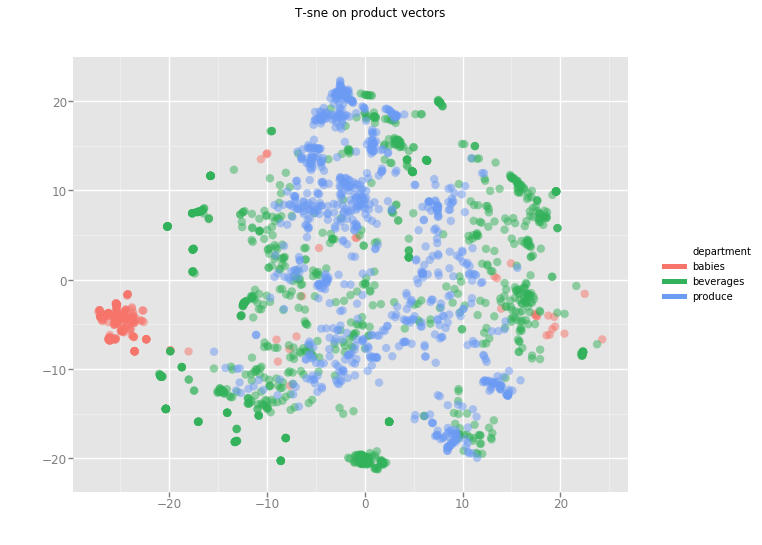

<ggplot: (-9223363246013712226)>

In [107]:
tsne_plot = ggplot(tsne_plot_df, aes(x = "x_tsne", y = "y_tsne", color = "department") ) \
        + geom_point(size = 70, alpha = 0.5) \
        + ggtitle("T-sne on product vectors") \
        + xlab(" ") + ylab(" ")
tsne_plot

----

# Class exercise - training embeddings

In [ ]:
# Please train embeddings with the following specifcations
# embedding size = 50
# negative samples = 12
# context size = 8
# optimizer = rmsprop
# optimizer learning rate = 0.025
# batch size = 128
# epochs = 1

In [ ]:
####### You are welcome to use the following skeleton code


# define input layers
input_target = Input((1,))
input_context = Input((1,))

# define embedding layers

# target
target = Embedding(input_dim = vocab_size, output_dim= emb_size, name = "rho")(input_target)
target = Reshape(target_shape = (emb_size, 1))(target)

# context
context = Embedding(input_dim = vocab_size, output_dim= emb_size, name = "alpha")(input_context)
context = Reshape(target_shape = (emb_size, 1))(context)

# concatenate model inputs and outputs
input_model = [input_target, input_context]

output_embeddings = Dot(axes = 1)([target, context])
output_embeddings

# resize embeddings
#output_model = Reshape((1,))(output_embeddings)
output_model = Flatten()(output_embeddings)
output_model

# complete model
output_model = Dense(1, activation = "sigmoid")(output_model)

# define as keras model
new_model = Model(inputs = input_model, outputs = output_model)

# optimizer
#### rmsprop

# compile model
# new_model.compile(optimizer = xxxx, loss = 'binary_crossentropy', metrics = ['acc'])

# model summary
# new_model.summary()